# Dogs vs Cats

Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать по [ссылке](https://github.com/a4tunado/lectures/tree/master/006). Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.
[Датасет](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [97]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import vgg19

from tensorflow.keras.applications import xception

from warnings import filterwarnings
filterwarnings('ignore')

import shutil

from keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)
print(tf.executing_eagerly())

2.15.0
True


In [5]:
!unzip dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [ ]:
!unzip train.zip

In [ ]:
!unzip test.zip

## Функции загрузки данных

In [79]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('/content/train/*.jpg')
test_files = glob('/content/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return xception.preprocess_input(img)  # предобработка для Xception

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=128):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализирую примеры для обучения

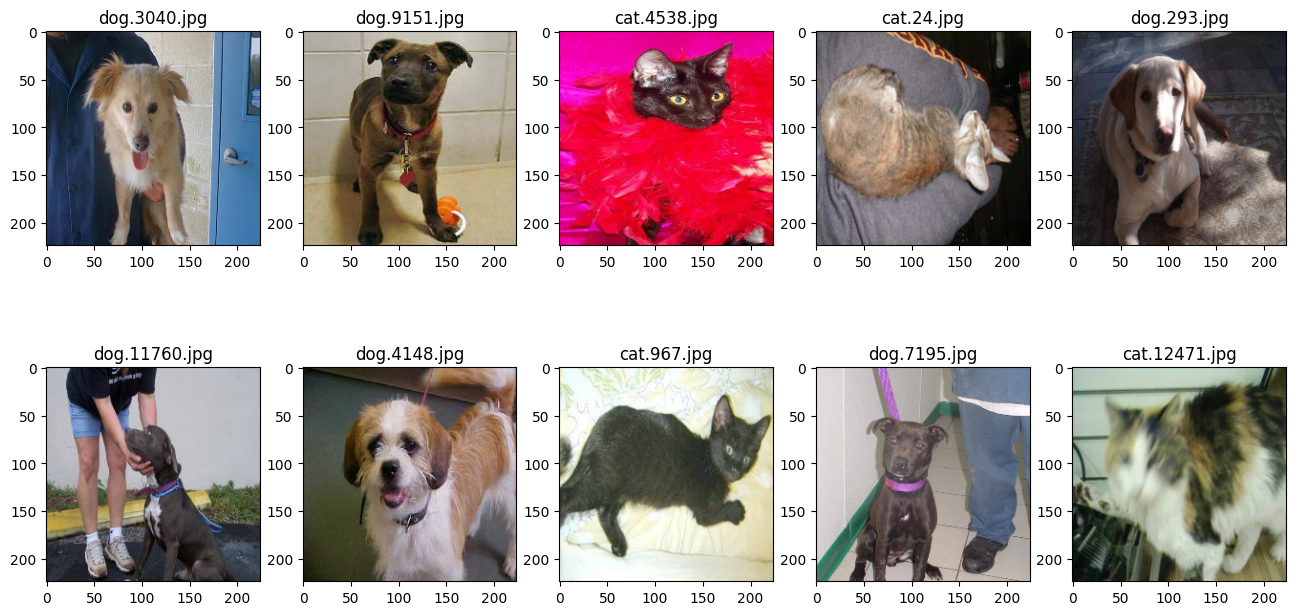

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Подготовка данных к обучению

In [64]:
# разделим папку data (original train)  на тренировочнуи и валидационную выборки

base_path = '/content/train'
categories = ['CAT' , 'DOG']
def move_images_to_specific_folder(file_path, category):
    for image_name in os.listdir(file_path):
        if category.lower() in image_name:
            shutil.move(os.path.join(base_path, image_name), os.path.join(base_path, category))

# создаем папки для котов и собак
for category in categories:
    path = os.path.join(base_path, category)
    os.mkdir(path)

# переносим файлы по своим категориям
for category in categories:
    move_images_to_specific_folder(base_path, category)

In [81]:
datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=25,
                                  #width_shift_range=0.15,
                                  #height_shift_range=0.15,
                                  shear_range=0.15,
                                  zoom_range=0.15,
                                  horizontal_flip=True,
                                  validation_split=0.2) # делим выборку

image_size = 299 #Xception image size
batch_size = 128

train_generator = datagen.flow_from_directory(base_path,
                                              class_mode='binary',
                                              batch_size = batch_size,
                                              target_size=(image_size,image_size),
                                              subset='training', shuffle=True, seed=42)
valid_generator = datagen.flow_from_directory(base_path,
                                              class_mode='binary',
                                              batch_size = batch_size,
                                              target_size=(image_size,image_size),
                                              subset='validation', shuffle=True, seed=42)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Загружаю предобученную модель

In [23]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [66]:
input_tensor = Input(shape=(image_size, image_size, 3))

In [82]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor,
    input_shape=(299, 299, 3),
    pooling=None,
    classes=2,
    classifier_activation="sigmoid",
)

In [74]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_14[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

In [83]:
base_model.trainable = False

## Добавляю слои

In [95]:
inputs = Input(shape=(299, 299, 3))



x = base_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(2048,
                          activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(2048,
                          activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256,
                          activation = 'relu')(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = Model(inputs = base_model.inputs, outputs = x, name='dogs_vs_cats')

## Архитектура модели

In [98]:
model.summary()

Model: "dogs_vs_cats"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_14[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0

## Компилирую модель и запускаю обучение

In [100]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, epsilon=1e-8)

In [101]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [102]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save_best = ModelCheckpoint(filepath = 'best_model.hdf5',verbose=1, save_best_only=True)

In [105]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch = 10, #train_generator.samples // batch_size,
                              validation_data = valid_generator,
                              validation_steps = valid_generator.samples // batch_size,
                              epochs = 20, callbacks=[save_best,early_stopping],
                              verbose=1)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9875
Epoch 1: val_loss improved from 0.25666 to 0.14287, saving model to best_model.hdf5
10/10 [==============================] - 176s 19s/step - loss: 0.0475 - accuracy: 0.9875 - val_loss: 0.1429 - val_accuracy: 0.9679
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9867
Epoch 2: val_loss did not improve from 0.14287
10/10 [==============================] - 171s 19s/step - loss: 0.0295 - accuracy: 0.9867 - val_loss: 0.1542 - val_accuracy: 0.9583
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9875
Epoch 3: val_loss improved from 0.14287 to 0.12644, saving model to best_model.hdf5
10/10 [==============================] - 175s 19s/step - loss: 0.0344 - accuracy: 0.9875 - val_loss: 0.1264 - val_accuracy: 0.9712
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9922
Epoch 4: val_los

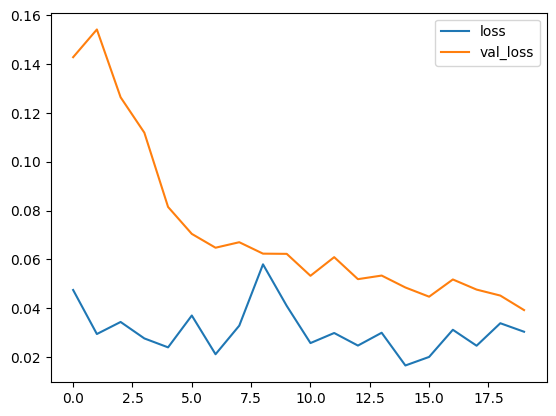

In [106]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [107]:
#лучшая модель
best_model = tf.keras.models.load_model('best_model.hdf5')
best_model.summary()

Model: "dogs_vs_cats"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_14[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0

## Предсказания на проверочной выборке

In [108]:
test_pred = best_model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 139s 11ms/step


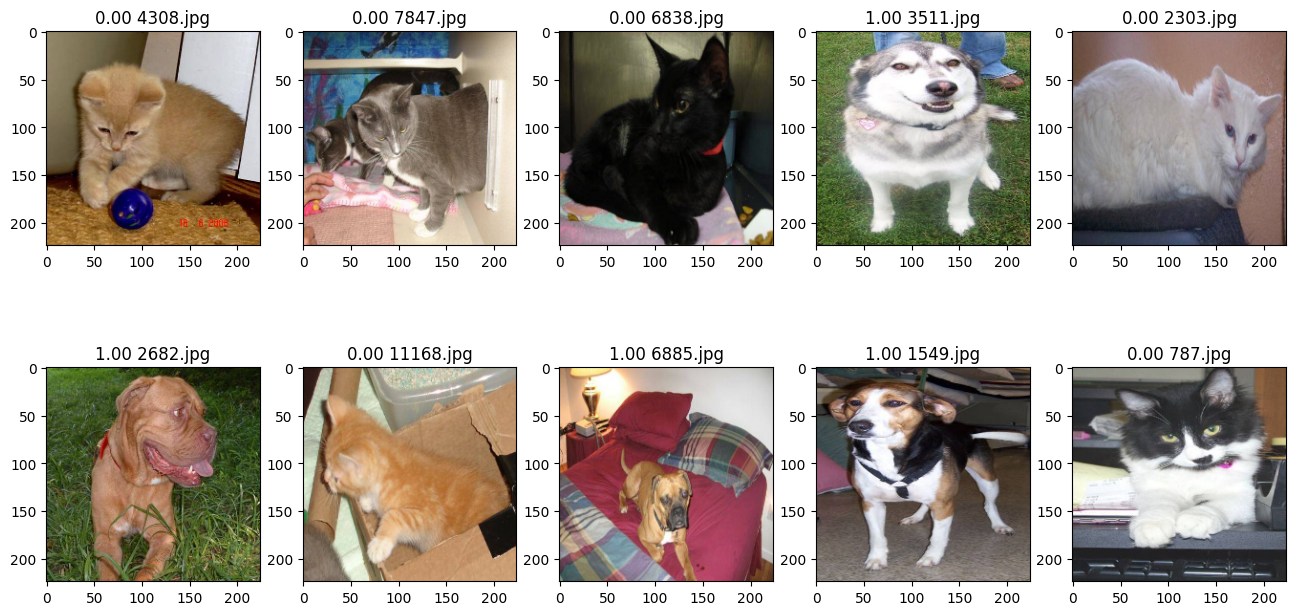

In [109]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовлю данные для отправки

In [110]:
import csv
import re

In [111]:
with open('submit.csv', mode = 'w', encoding = 'utf-8') as dst:
  file_writer = csv.writer(dst, delimiter = ',', lineterminator="\r")
  file_writer.writerow(["id", "label"])


  for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))
        #dst.write('%s,%s\n' % (i, p))

In [ ]:
# Xception score = 0.17516

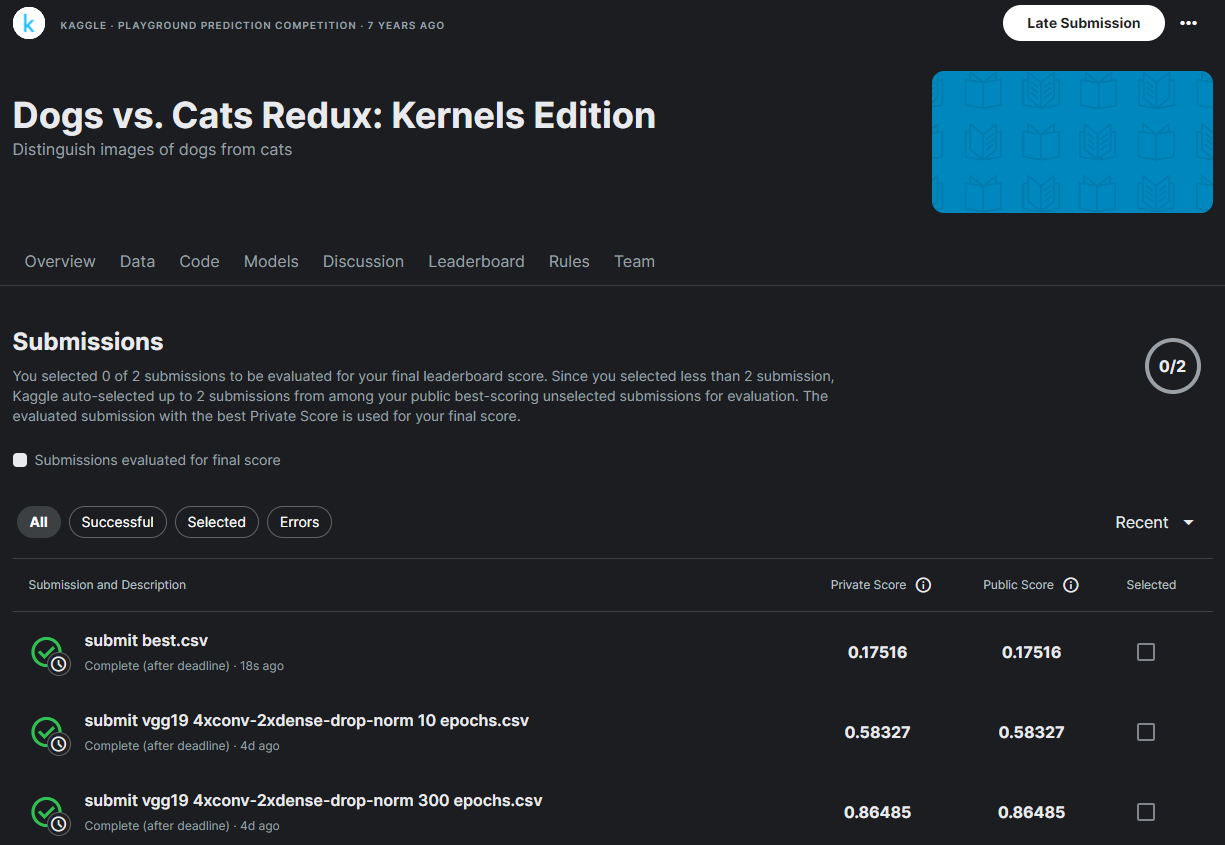